In [1]:
import cmasher as cmr
from matplotlib import rcParams
import matplotlib.pyplot as plt
colors = cmr.take_cmap_colors('cmr.bubblegum', 6, cmap_range=(0.05, 0.95), return_fmt='hex')
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 14
rcParams['mathtext.default'] = 'regular'
from matplotlib import colors as cr
import pandas as pd
import seaborn as sns
import numpy as np
from astropy.cosmology import Planck18_arXiv_v2 as Planck18
from astropy import units as u

import catgen
import sfh
import param_dists as pdf

In [2]:
n_sample = 1000000
n_downsample=100
path_prefix = '/Users/kbreivik/projects/emulator_models/'
paths = ['alpha_0.25', 'alpha_1', 'alpha_3', 'alpha_5']
labels= [r'$\alpha=0.25$',r'$\alpha=1$',r'$\alpha=3$', r'$\alpha=5$']


path_select = 0
path = path_prefix + paths[path_select]
label = labels[path_select]

metallicities = ['0.000085', '0.00012673', '0.00018896', '0.00028173', '0.00042005',
                 '0.00062629', '0.00093378', '0.00139224', '0.00207579', '0.00309496',
                 '0.00461451', '0.00688012', '0.0102581', '0.01529458', '0.02280385', '0.034']
mets = np.array([0.00008500, 0.00012673, 0.00018896, 0.00028173, 0.00042005,
                 0.00062629, 0.00093378, 0.00139224, 0.00207579, 0.00309496,
                 0.00461451, 0.00688012, 0.01025810, 0.01529458, 0.02280385, 0.03400000])


In [3]:
help(catgen.Catalog)

Help on class Catalog in module catgen:

class Catalog(builtins.object)
 |  Catalog(dat_path, merger_type, sfr_model, met_grid)
 |  
 |  Class for building a generic catalog of merging compact objects
 |  from COSMIC data in metallicity grid
 |  
 |  Attributes
 |  ----------
 |  merger_type : `str`
 |      Defines the type of merging compact objects with options
 |      including: 'BNS', 'NSBH', 'BBH'
 |  
 |  Methods defined here:
 |  
 |  __init__(self, dat_path, merger_type, sfr_model, met_grid)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  build_cat(self, n_sample, n_downsample, sigma_logZ=0.5, z_max=20)
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the object (if defined)



In [4]:
cat = catgen.Catalog(dat_path=path,
                     merger_type='BBH',
                     sfr_model=sfh.mf_17,
                     met_grid=mets)

### build a catalog which contains mergers in a comoving volume of [Gpc$^3$]

In [5]:
mergers, norm_fac = cat.build_cat(n_sample=n_sample, n_downsample=n_downsample)

/Users/kbreivik/Documents/Github/cosmic-mergers/utils.py:118: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  dat = np.array(dat)
100%|██████████| 16/16 [00:00<00:00, 61.31it/s] 


#### Build the pdf of the merger lookback time distribution

In [6]:
p_tlb = pdf.get_dN_dtlb_dV(mergers.t_merge)

#### generate a set of lookback times and redshifts to evaulate the pdf
##### note that everything is in units of a comoving volume!

In [7]:
z_max = 15
z = np.expm1(np.linspace(0, np.log1p(z_max), 1000))
tlb = Planck18.lookback_time(z).to(u.Myr).value

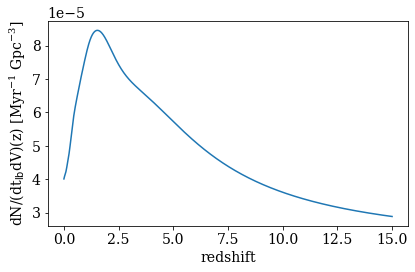

In [8]:
plt.plot(z, p_tlb(tlb))
plt.xlabel('redshift')
plt.ylabel(r'dN/(dt$_{\rm{lb}}$dV)(z) [Myr$^{-1}$ Gpc$^{-3}$]')
plt.tight_layout()

#### Now we can use the normalization factor which evaluates the average mass of BBH progenitors formed per unit solar mass from the merger catalog to get the rate!

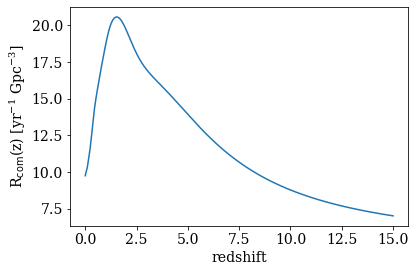

In [9]:
plt.plot(z, p_tlb(tlb) * norm_fac)
plt.xlabel('redshift')
plt.ylabel(r'R$_{\rm{com}}$(z) [yr$^{-1}$ Gpc$^{-3}$]')
plt.tight_layout()

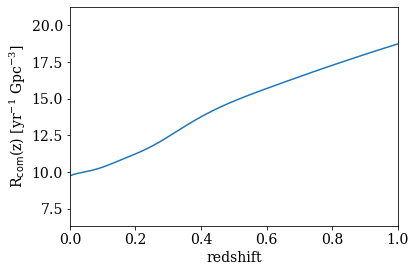

In [10]:
plt.plot(z, p_tlb(tlb) * norm_fac)
plt.xlabel('redshift')
plt.ylabel(r'R$_{\rm{com}}$(z) [yr$^{-1}$ Gpc$^{-3}$]')
plt.xlim(0, 1)
plt.tight_layout()

#### We can also get the pdf of merger redshifts in the universe as measured from the detector frame

In [11]:
pz = pdf.get_pz(mergers.t_merge, z_max=15)

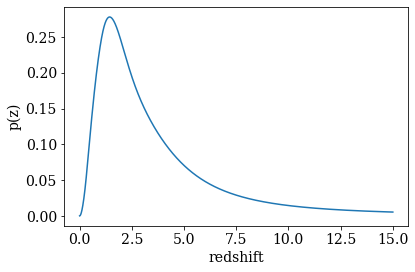

In [12]:
plt.plot(z, pz(z))
plt.xlabel('redshift')
plt.ylabel(r'p(z)')
#plt.yscale('log')
#plt.ylim(1e-5, 1e1)
plt.tight_layout()